# FINAL PROJECT: BIG DATA & DATA MINING (ST168)
## Analisis Sentimen Ulasan Produk iPhone Menggunakan Algoritma SVM

---
**Identitas Mahasiswa:**
* **Nama:** Zulfa Meydita Rahma
* **NIM:** 23.11.5512
* **Program Studi:** S1 Informatika
* **Fakultas:** Ilmu Komputer
* **Universitas:** Universitas Amikom Yogyakarta

**Detail Proyek:**
* **Dataset:** iPhone Customer Reviews (Kaggle)
* **Metode:** Support Vector Machine (SVM) dengan Chi-Square Feature Selection
---

##1: Inisialisasi Library dan Pemuatan Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Konfigurasi NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Konfigurasi tampilan visualisasi
%matplotlib inline
sns.set_theme(style="whitegrid")

# Pemuatan Dataset
try:
    df = pd.read_csv('iphone.csv')
    print("=" * 100)
    print("Status: Dataset berhasil dimuat.")
    print("=" * 100)
    print(f"Total Baris Data : {df.shape[0]}")
    print(f"Total Kolom Data : {df.shape[1]}")
    print('='*100)
    print("Informasi Tipe Data:")
    print('='*100)
    print(df.info())
    print('='*100)
    print("Sampel Data Mentah:")
    print('='*100)
    print(df.head())
    print('='*100)
    print("Pengecekan Missing Values:")
    print('='*100)
    print(df.isnull().sum())
    print('-'*100)
except FileNotFoundError:
    print("Error: File 'iphone.csv' tidak ditemukan. Mohon unggah file terlebih dahulu.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ULPA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ULPA\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ULPA\AppData\Roaming\nltk_data...


Status: Dataset berhasil dimuat.
Total Baris Data : 3062
Total Kolom Data : 11
Informasi Tipe Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3062 entries, 0 to 3061
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   productAsin        3062 non-null   object
 1   country            3062 non-null   object
 2   date               3062 non-null   object
 3   isVerified         3062 non-null   bool  
 4   ratingScore        3062 non-null   int64 
 5   reviewTitle        3062 non-null   object
 6   reviewDescription  2976 non-null   object
 7   reviewUrl          3046 non-null   object
 8   reviewedIn         3062 non-null   object
 9   variant            3062 non-null   object
 10  variantAsin        3062 non-null   object
dtypes: bool(1), int64(1), object(9)
memory usage: 242.3+ KB
None
Sampel Data Mentah:
  productAsin country        date  isVerified  ratingScore  \
0  B09G9BL5CP   India  11-08-2024 

##2: Pra-pemrosesan Data (Data Preprocessing)

In [4]:
# 1. Penanganan Missing Values
df.dropna(subset=['reviewDescription'], inplace=True)

# 2. Pelabelan Sentimen (Labeling)
# 1-2: Negative, 4-5: Positive, 3: Dihapus (Netral)
def set_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating >= 4:
        return 'Positive'
    else:
        return 'Neutral'

df['sentiment'] = df['ratingScore'].apply(set_sentiment)
df_clean = df[df['sentiment'] != 'Neutral'].copy()

# 3. Pembersihan Teks (Text Cleaning & Lemmatization)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Konversi ke huruf kecil
    text = str(text).lower()
    # Menghapus karakter non-alfabet
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenisasi dan Lematisasi
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df_clean['clean_text'] = df_clean['reviewDescription'].apply(preprocess_text)

print("Status: Preprocessing selesai.")
print(f"Jumlah data bersih: {len(df_clean)} baris")
print("\nSampel Data Hasil Preprocessing:")
print(df_clean[['reviewDescription', 'clean_text', 'sentiment']].head())

Status: Preprocessing selesai.
Jumlah data bersih: 2741 baris

Sampel Data Hasil Preprocessing:
                                   reviewDescription  \
0  Every thing is good about iPhones, there's not...   
1  It look so fabulous, I am android user switche...   
2  I tried to flip camera while recording but no ...   
3                                       100% genuine   
4         Happy to get the iPhone 13 in Amazon offer   

                                          clean_text sentiment  
0  every thing good iphones there nothing compare...  Positive  
1  look fabulous android user switched apple perf...  Positive  
2  tried flip camera recording facility added pau...  Positive  
3                                            genuine  Positive  
4                      happy get iphone amazon offer  Positive  


##3: Visualisasi Data (Exploratory Data Analysis)

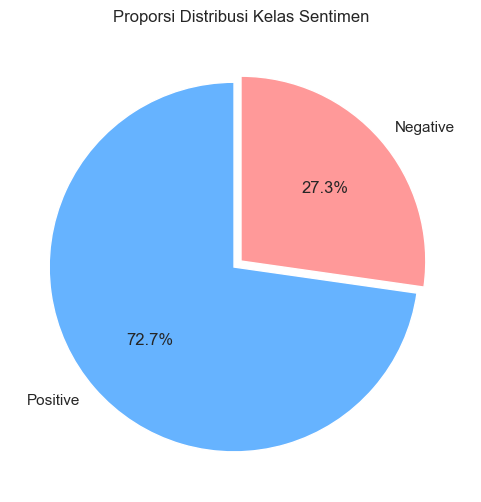


Menampilkan WordCloud...


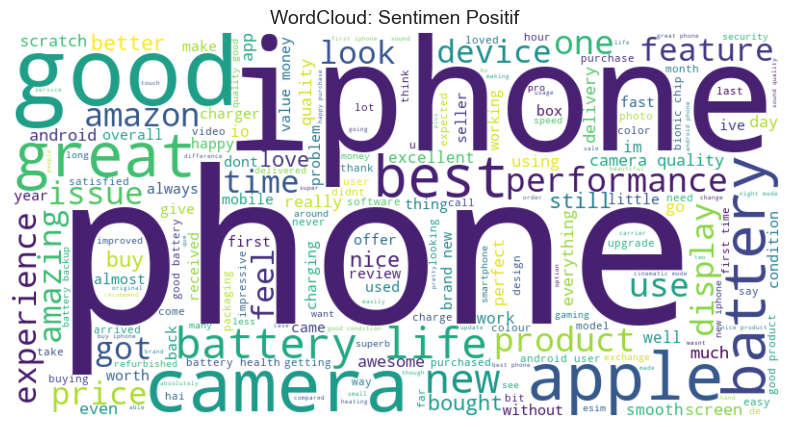

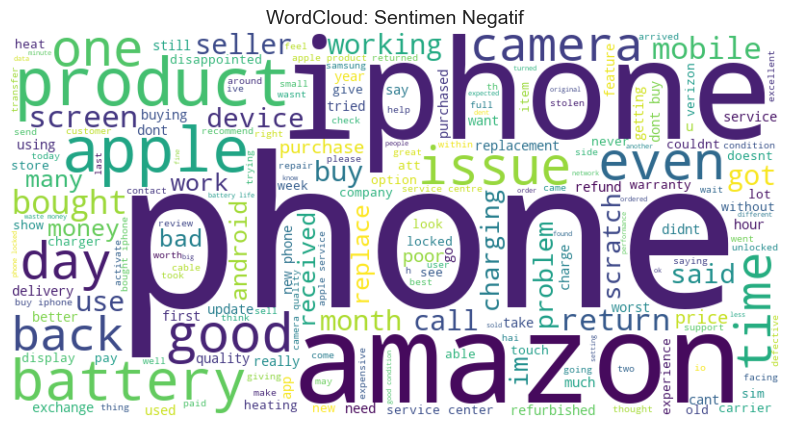

In [5]:
# Visualisasi 1: Distribusi Kelas Sentimen (Pie Chart)
plt.figure(figsize=(6, 6))
counts = df_clean['sentiment'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'], explode=(0.05, 0))
plt.title('Proporsi Distribusi Kelas Sentimen')
plt.show()

# Visualisasi 2: WordCloud
def generate_wordcloud(text_data, title):
    text = " ".join(text_data)
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis', random_state=42).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

print("\nMenampilkan WordCloud...")
generate_wordcloud(df_clean[df_clean['sentiment'] == 'Positive']['clean_text'], 'WordCloud: Sentimen Positif')
generate_wordcloud(df_clean[df_clean['sentiment'] == 'Negative']['clean_text'], 'WordCloud: Sentimen Negatif')

##4: Ekstraksi Fitur dan Pembagian Data

In [6]:
# 1. TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_clean['clean_text'])
y = df_clean['sentiment']

# 2. Feature Selection (Chi-Square)
# Mengambil 2000 fitur terbaik yang paling berpengaruh terhadap sentimen
k_best = 2000
selector = SelectKBest(chi2, k=k_best)
X_selected = selector.fit_transform(X_tfidf, y)

# 3. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

print("Status: Feature Engineering selesai.")
print(f"Dimensi Fitur Awal (TF-IDF) : {X_tfidf.shape}")
print(f"Dimensi Fitur Terseleksi    : {X_selected.shape}")
print(f"Jumlah Data Training        : {X_train.shape[0]}")
print(f"Jumlah Data Testing         : {X_test.shape[0]}")

Status: Feature Engineering selesai.
Dimensi Fitur Awal (TF-IDF) : (2741, 5000)
Dimensi Fitur Terseleksi    : (2741, 2000)
Jumlah Data Training        : 2192
Jumlah Data Testing         : 549


##5: Pemodelan dan Evaluasi

Laporan Klasifikasi (Classification Report):
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.91      0.62      0.73       143
    Positive       0.88      0.98      0.93       406

    accuracy                           0.88       549
   macro avg       0.89      0.80      0.83       549
weighted avg       0.89      0.88      0.88       549

------------------------------------------------------------
Akurasi Model: 88.34%


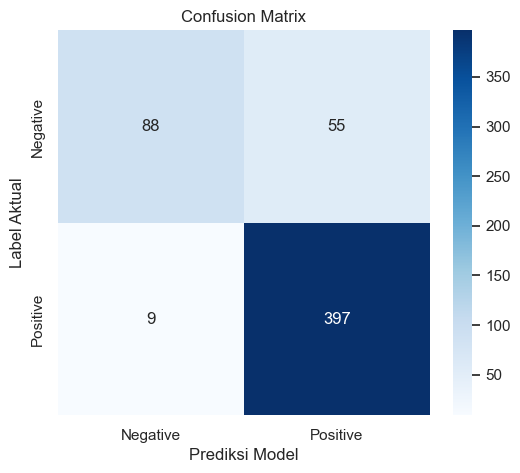

In [7]:
# Pelatihan Model SVM
model_svm = SVC(kernel='linear', probability=True, random_state=42)
model_svm.fit(X_train, y_train)

# Prediksi pada Data Test
y_pred = model_svm.predict(X_test)

# Menampilkan Metrik Evaluasi
print("Laporan Klasifikasi (Classification Report):")
print("-" * 60)
print(classification_report(y_test, y_pred))
print("-" * 60)
print(f"Akurasi Model: {accuracy_score(y_test, y_pred):.2%}")

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Aktual')
plt.show()

# Penyimpanan Model (Opsional)
with open('svm_model.pkl', 'wb') as f: pickle.dump(model_svm, f)
with open('tfidf.pkl', 'wb') as f: pickle.dump(vectorizer, f)
with open('chi2.pkl', 'wb') as f: pickle.dump(selector, f)

##6: Simulasi Prediksi (Inference)

In [8]:
def predict_new_review(text):
    # Preprocessing
    clean = preprocess_text(text)
    # Transformasi Fitur
    vec = vectorizer.transform([clean])
    sel = selector.transform(vec)
    # Prediksi
    sentiment = model_svm.predict(sel)[0]
    confidence = np.max(model_svm.predict_proba(sel))
    return sentiment, confidence

# Data Uji Simulasi
sample_reviews = [
    "The battery life is phenomenal, easily lasts two days with heavy use.",
    "Total waste of money. The phone started overheating and the screen is flickering.",
    "The camera takes professional-grade photos but the charging speed is quite slow.",
    "Delivery was fast, but the product is not working as expected."
]

print(f"{'Review Content':<70} | {'Sentiment':<10} | {'Confidence'}")
print("-" * 105)

for review in sample_reviews:
    pred, conf = predict_new_review(review)
    print(f"{review[:68]:<70} | {pred:<10} | {conf:.2%}")

Review Content                                                         | Sentiment  | Confidence
---------------------------------------------------------------------------------------------------------
The battery life is phenomenal, easily lasts two days with heavy use   | Positive   | 94.70%
Total waste of money. The phone started overheating and the screen i   | Negative   | 99.05%
The camera takes professional-grade photos but the charging speed is   | Positive   | 62.48%
Delivery was fast, but the product is not working as expected.         | Positive   | 95.08%
